Aggiungo al path relativo alla posizione del notebok la cartella *src* contenente le varie funzioni utilizzate e faccio l'import e il reload dei moduli.

In [20]:

import sys
from pathlib import Path
import importlib

root = Path.cwd().parent 
src = root / "src"

if str(src) not in sys.path:
    sys.path.append(str(src))

modules = ["task1","task2","task3","task5"]
for mod_name in modules:
    mod = importlib.import_module(mod_name)
    importlib.reload(mod)

from task1 import *
from task2 import *
from task3 import *
from task5 import *

# Task 1

Carichiamo il dataset e applichiamo la funzione *exclude_shoppers()* per rimuovere le righe associate agli articoli di tipo SHOPPERS.

In [21]:
df = load_dataset()
df_clean = exclude_shoppers(df)

Definiamo un dizionario che mappa ciascun livello di merchandising alla relativa colonna descrittiva. Questo ci permette di iterare facilmente sui livelli della gerarchia dell'albero merceologico e generare in sequenza le successive analisi per ognuno di essi.

In [22]:
levels = {
    "liv1": "descr_liv1",
    "liv2": "descr_liv2",
    "liv3": "descr_liv3",
    "liv4": "descr_liv4"
}

Per ciascun livello di merchandising, richiamiamo la funzione *plot_frequency()* per generare i grafici delle frequenze per le categorie più e meno ricorrenti.

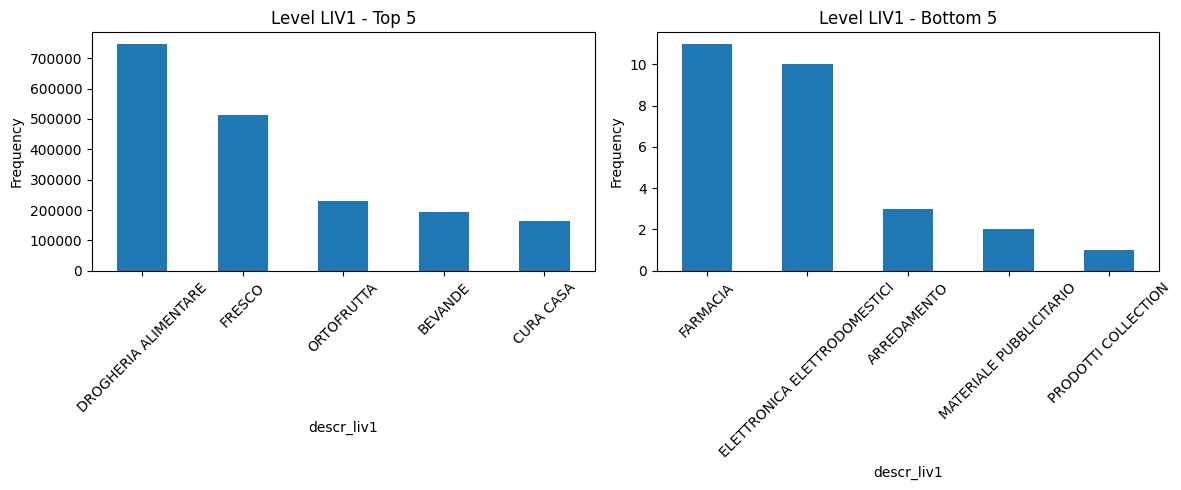

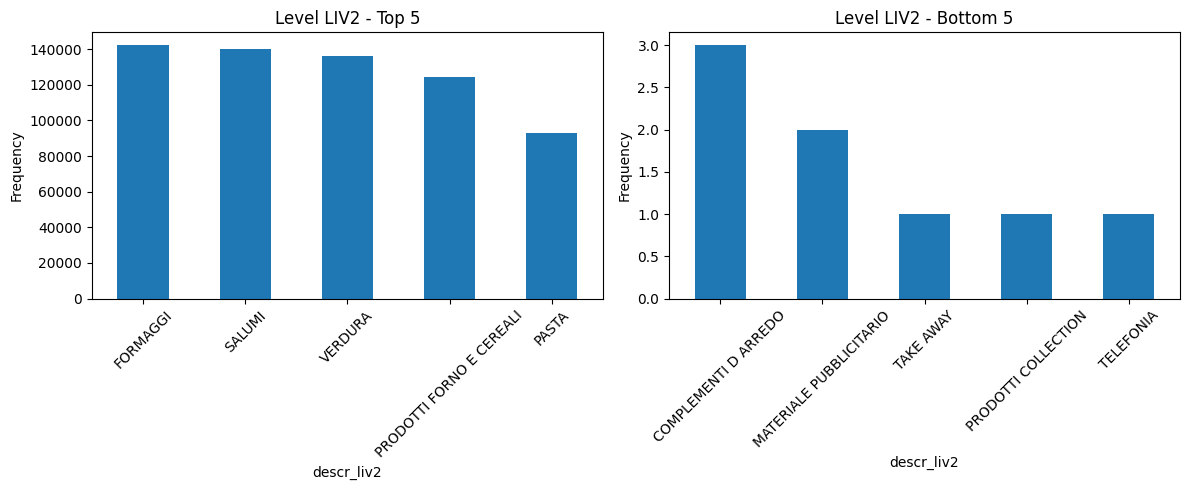

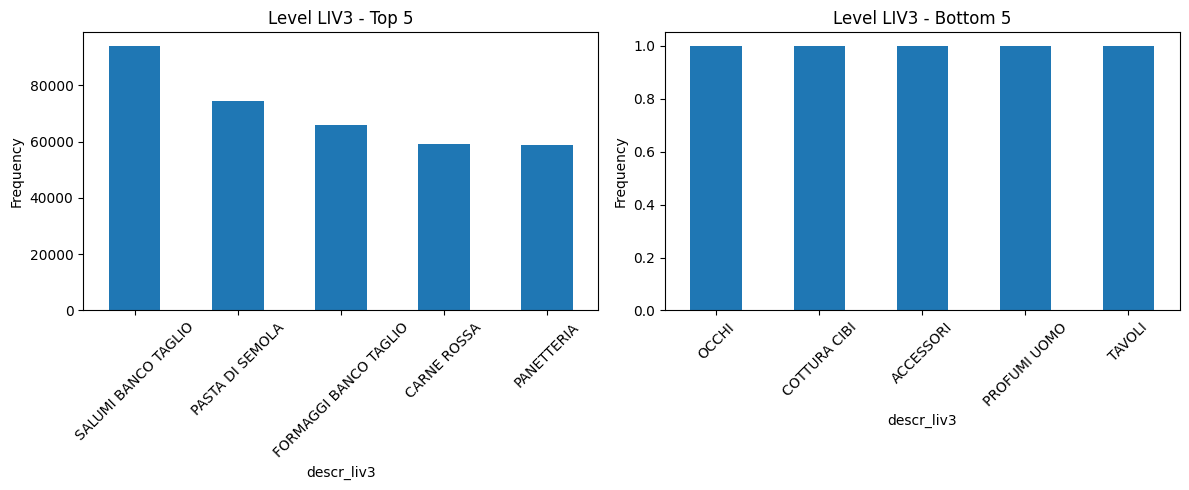

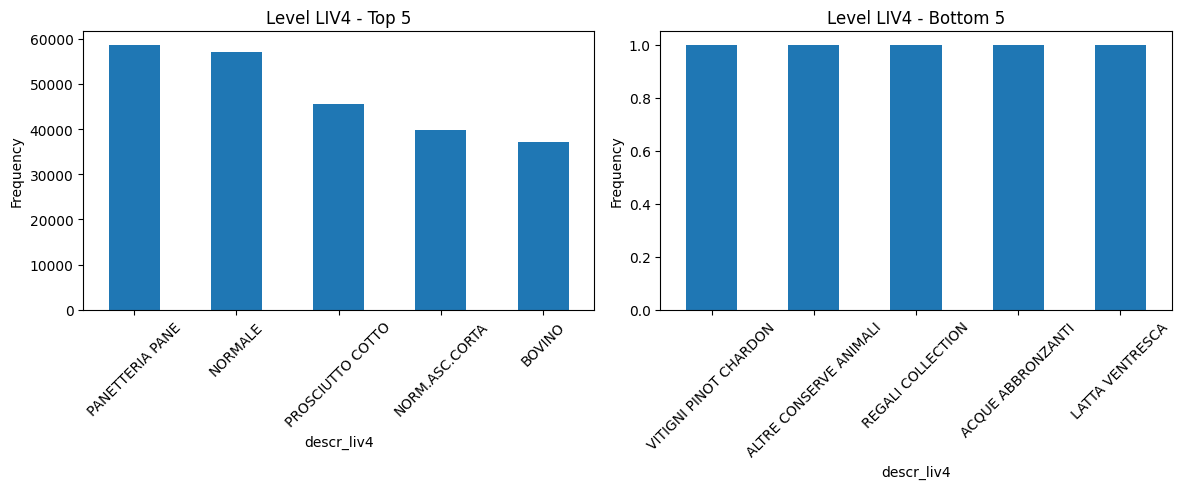

In [23]:
for level, desc_col in levels.items():
    plot_frequency(df_clean, desc_col, f"Level {level.upper()}")

# Task 2

Definiamo una lista di intervalli temporali per poter suddividere il dataset.  
Ciascuno di essi è costituito da : 
- Nome dell'intervallo
- Data di inizio
- Data di fine

In [24]:
time_ranges = [
    ("Range 1: Gen - Metà Maggio", "2023-01-01", "2023-05-15"),
    ("Range 2: Metà Maggio - Settembre", "2023-05-16", "2023-09-30"),
    ("Range 3: Ott - Dic", "2023-10-01", "2023-12-31")
]

Per ciascun intervallo applichiamo un filtro sul dataframe con la funzione *filter_by_date_range(dataframe, start_date, end_date)* e poi esattamente come fatto in precedenza generiamo i grafici di frequenza per tutti i livelli di merchandising.

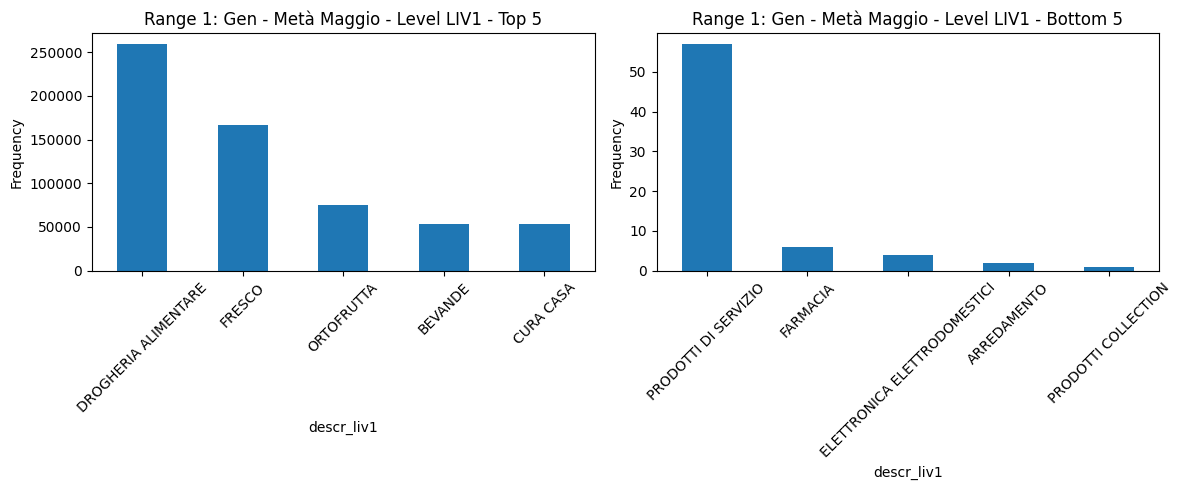

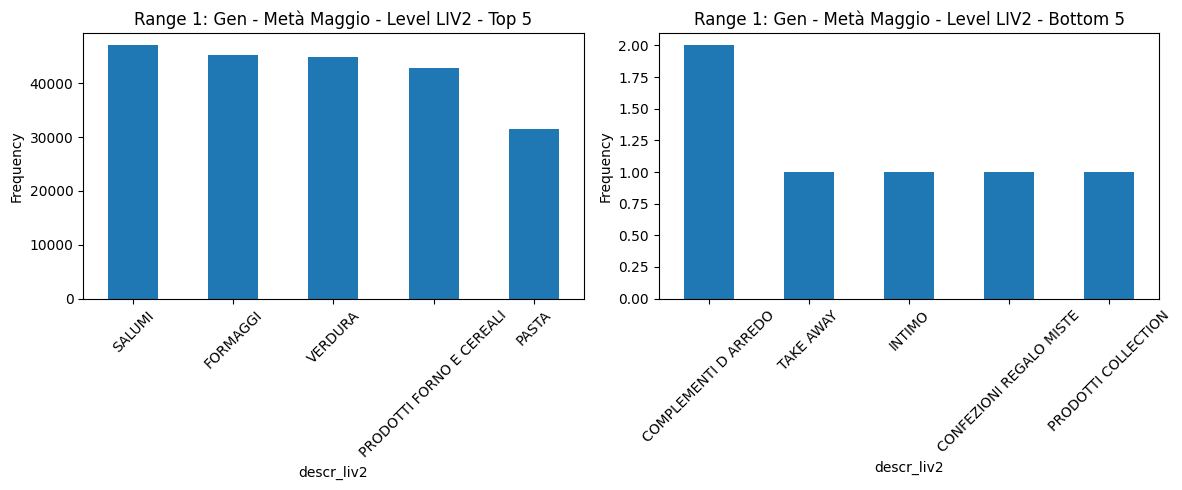

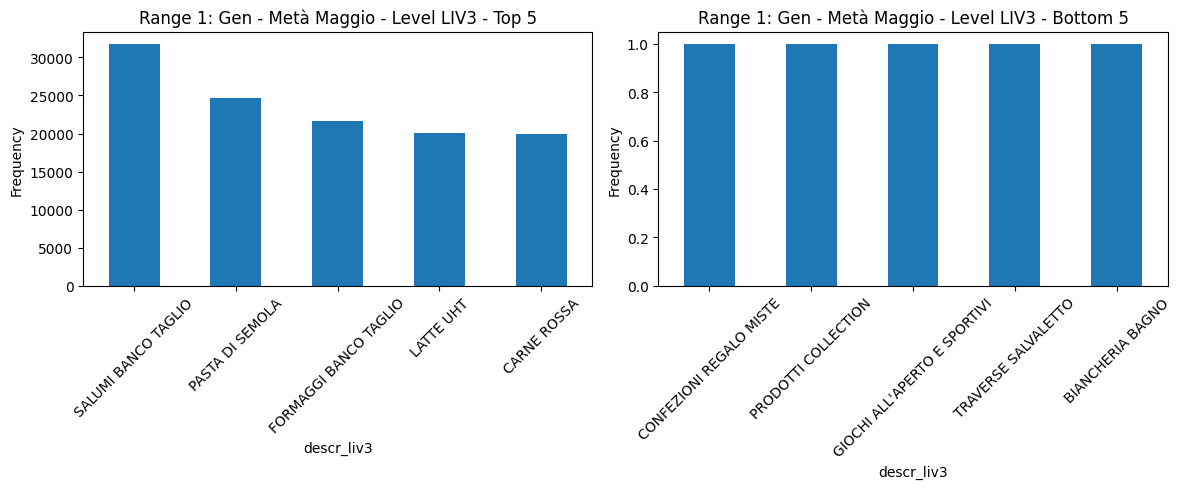

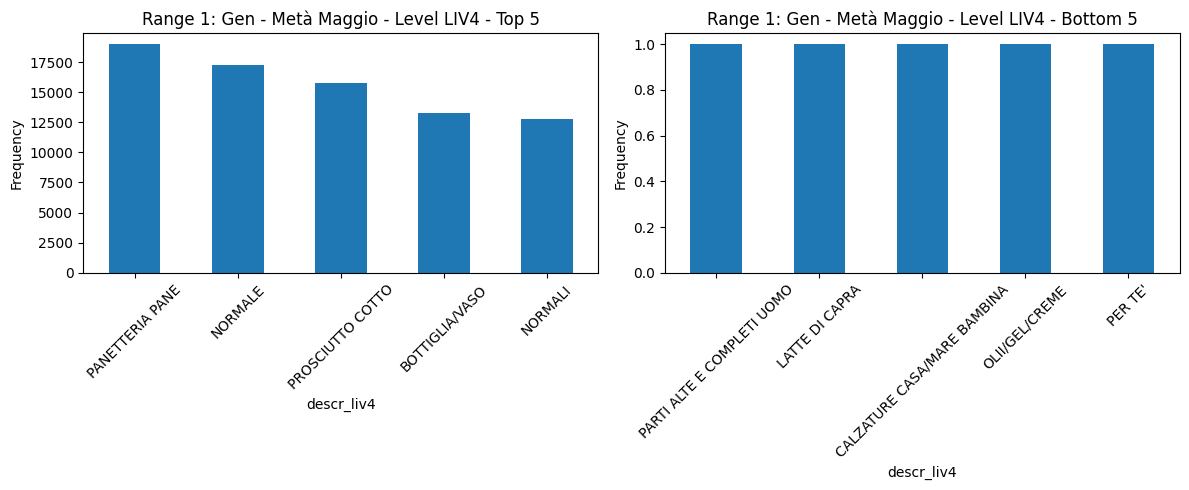

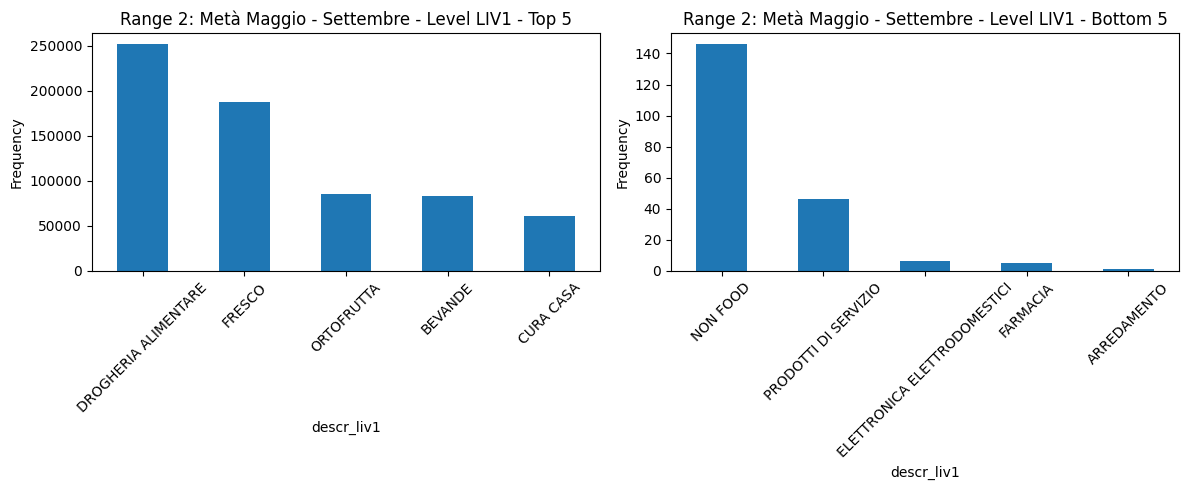

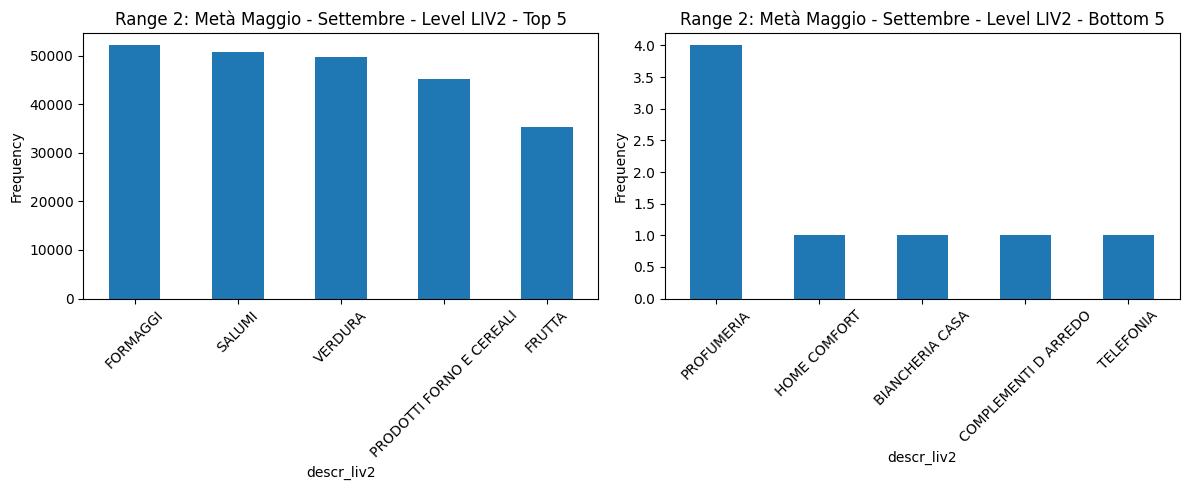

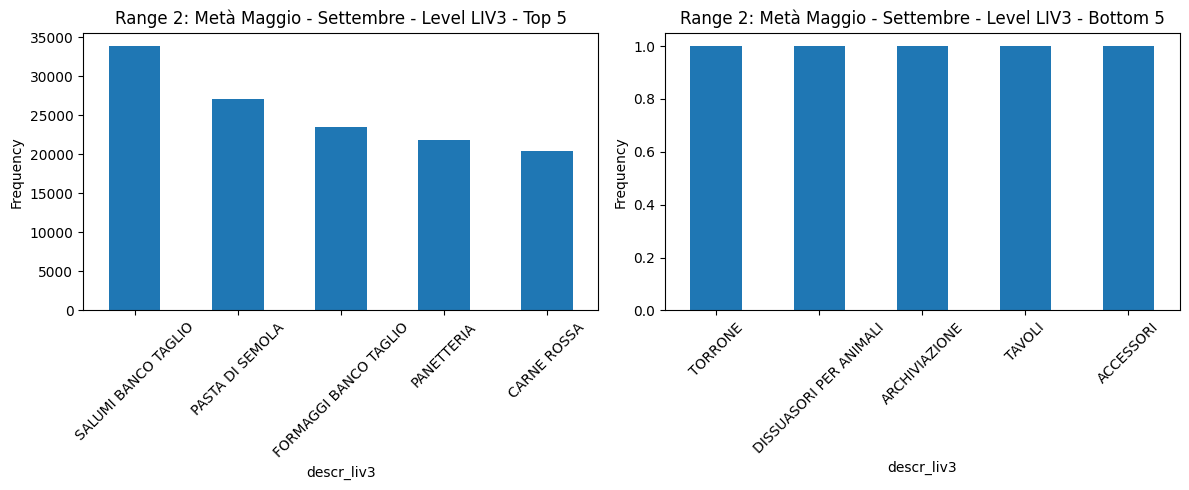

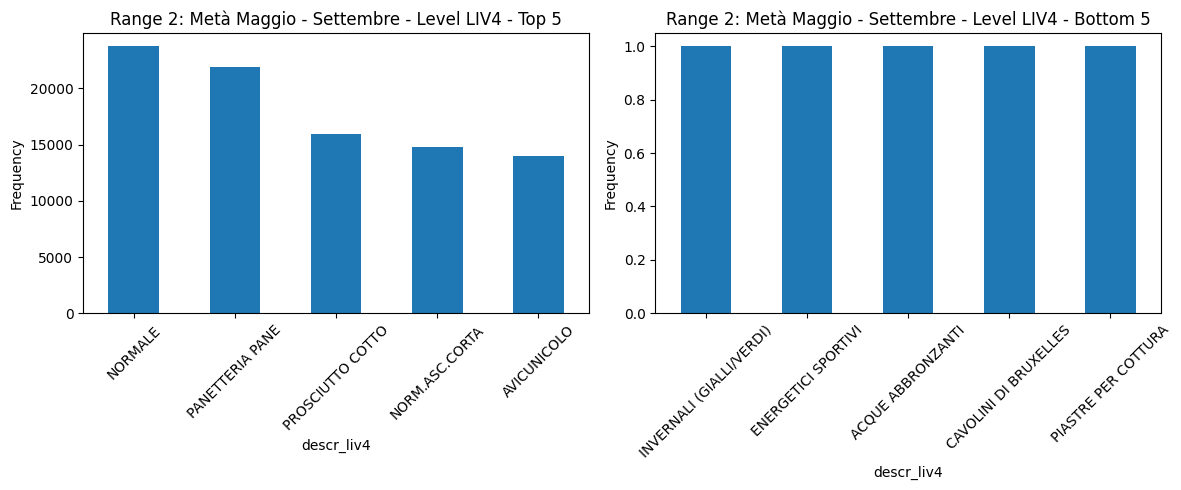

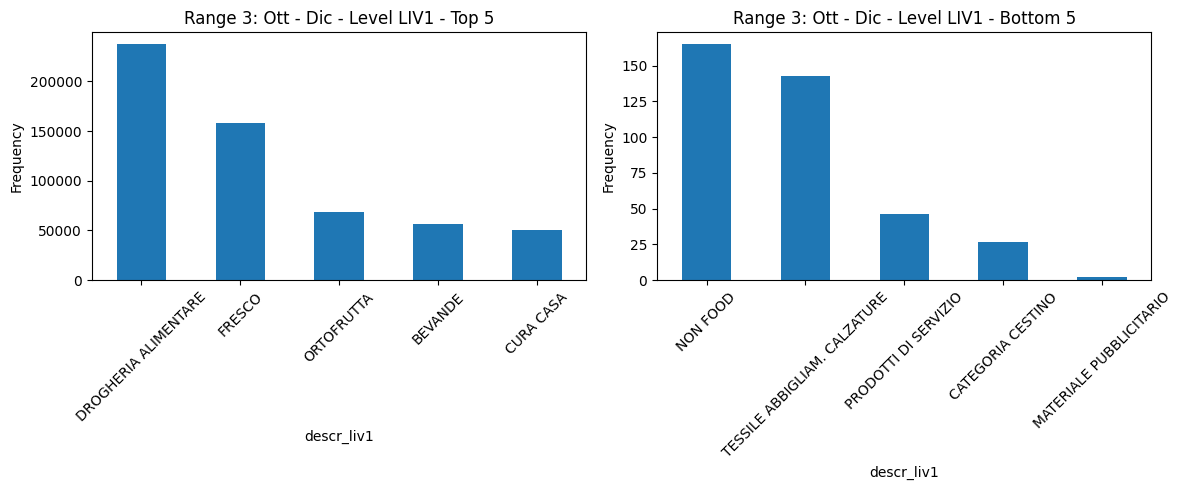

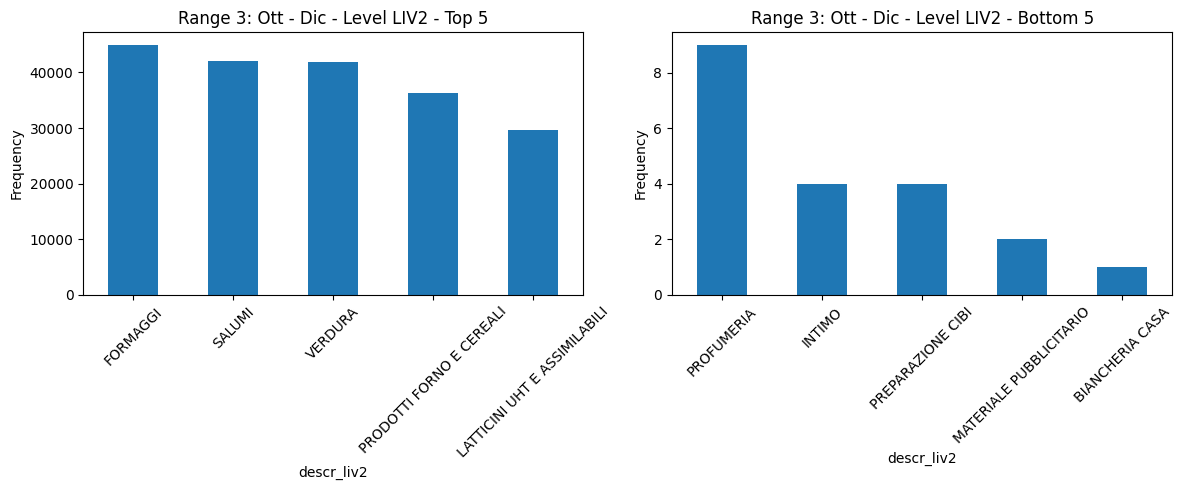

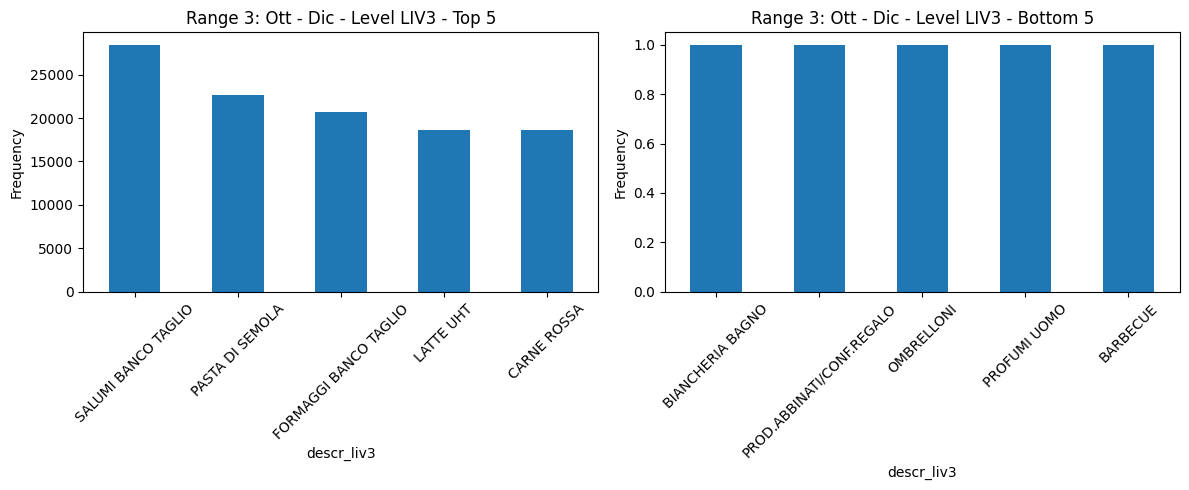

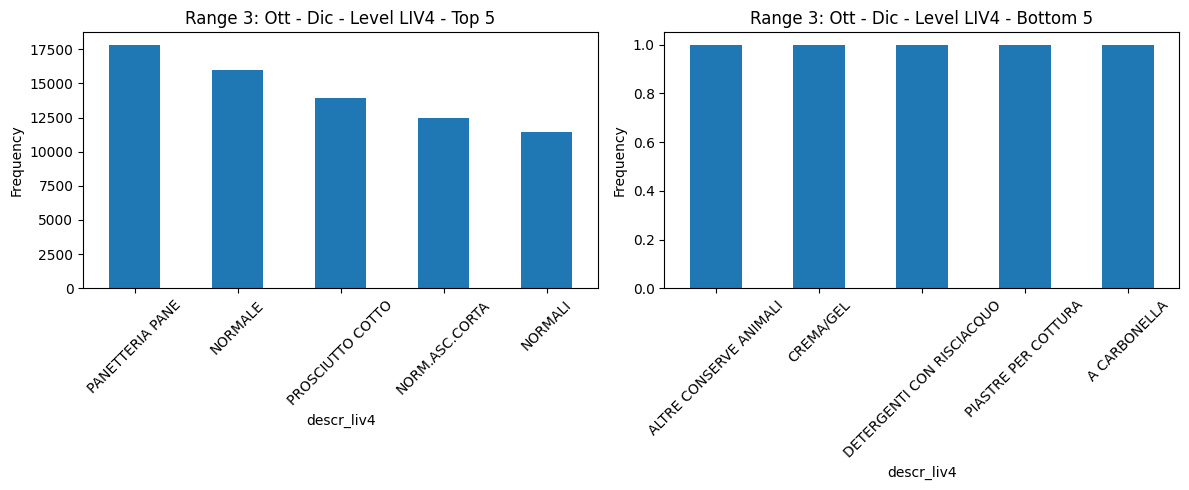

In [25]:
for range_name, start_date, end_date in time_ranges:
    df_range = filter_by_date_range(df_clean, start_date, end_date) 
    for level, desc_col in levels.items():
        plot_frequency(df_range, desc_col, f"{range_name} - Level {level.upper()}")

Definiamo un'altra lista per poter suddividere il dataset in intervalli temporali orari.  
Ciascuno di essi è costituito da : 
- Nome dell'intervallo
- Ora di inizio
- Ora di fine

In [26]:
slot_ranges = [
    ("Range 1: 08:30–12:30", "08:30", "12:30"),
    ("Range 2: 12:30–16:30", "12:30", "16:30"),
    ("Range 3: 16:30–20:30", "16:30", "20:30")
]

Per ciascun intervallo applichiamo un filtro sul dataframe con la funzione *filter_by_hour_range(dataframe, start_hour, end_hour)* e poi esattamente come fatto in precedenza generiamo i grafici di frequenza per tutti i livelli di merchandising.

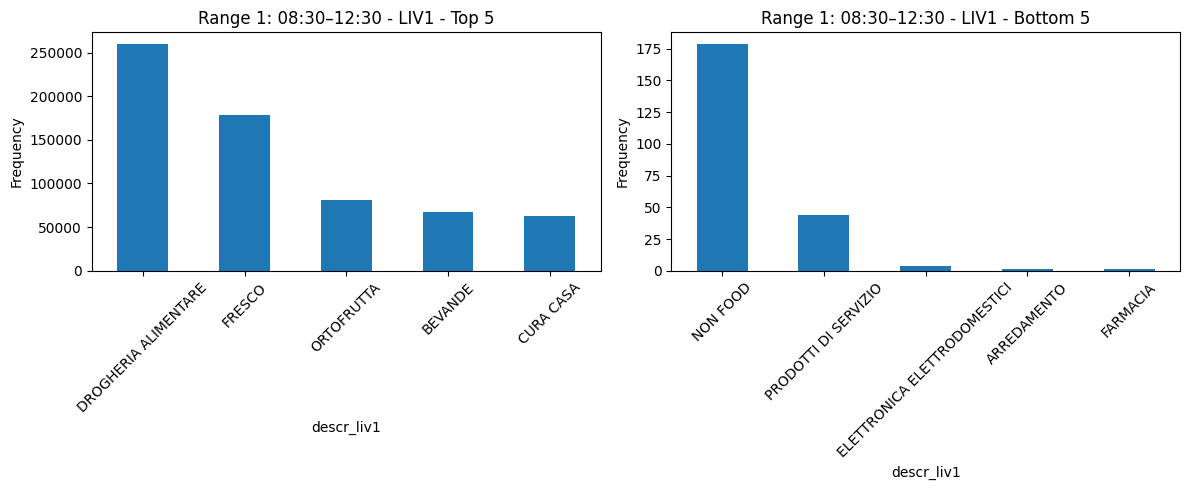

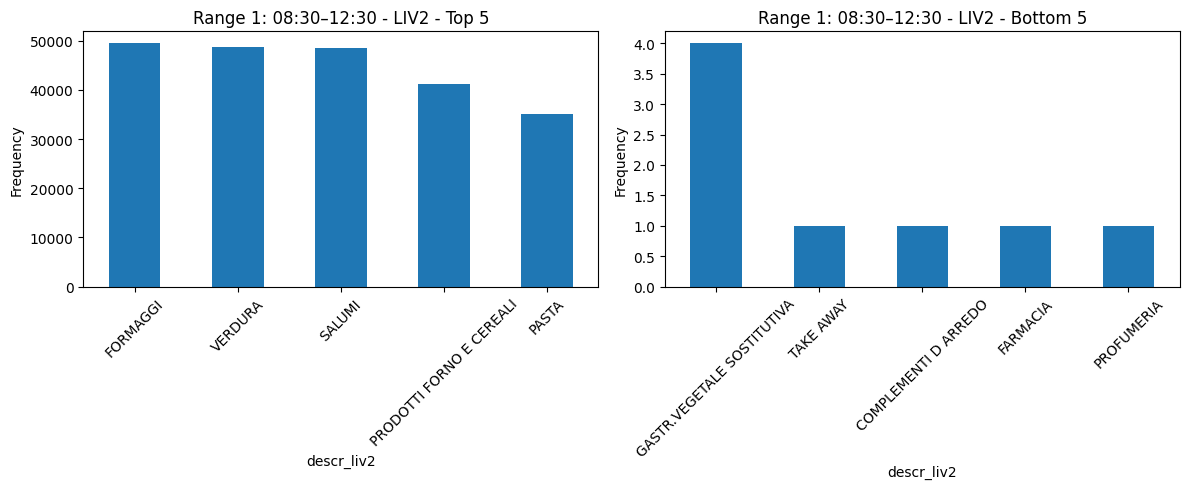

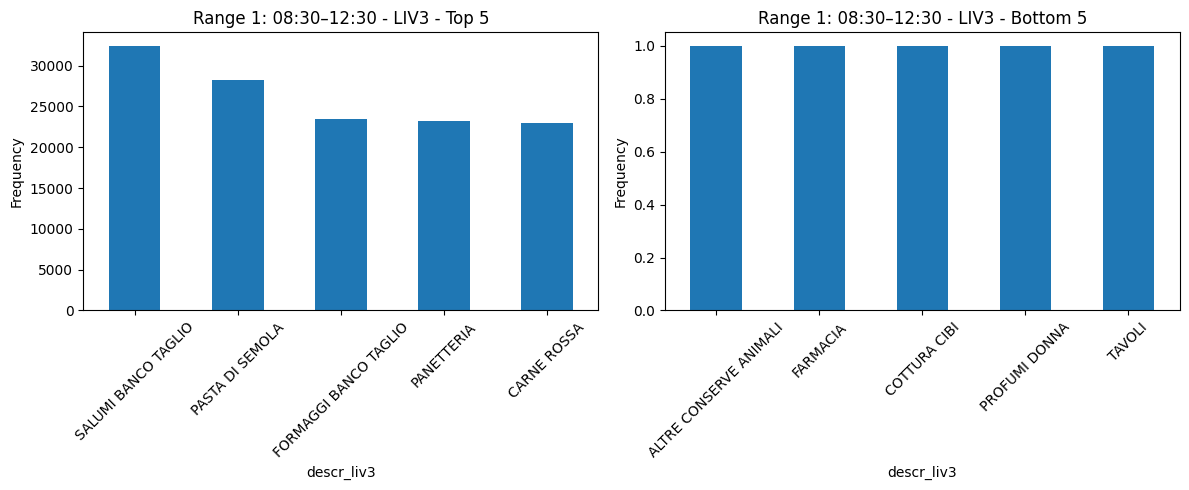

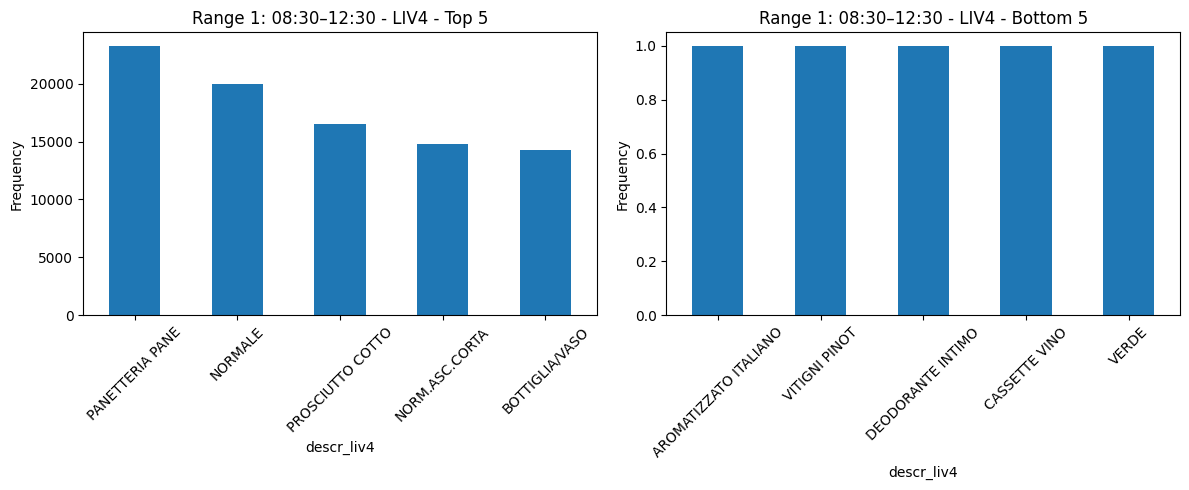

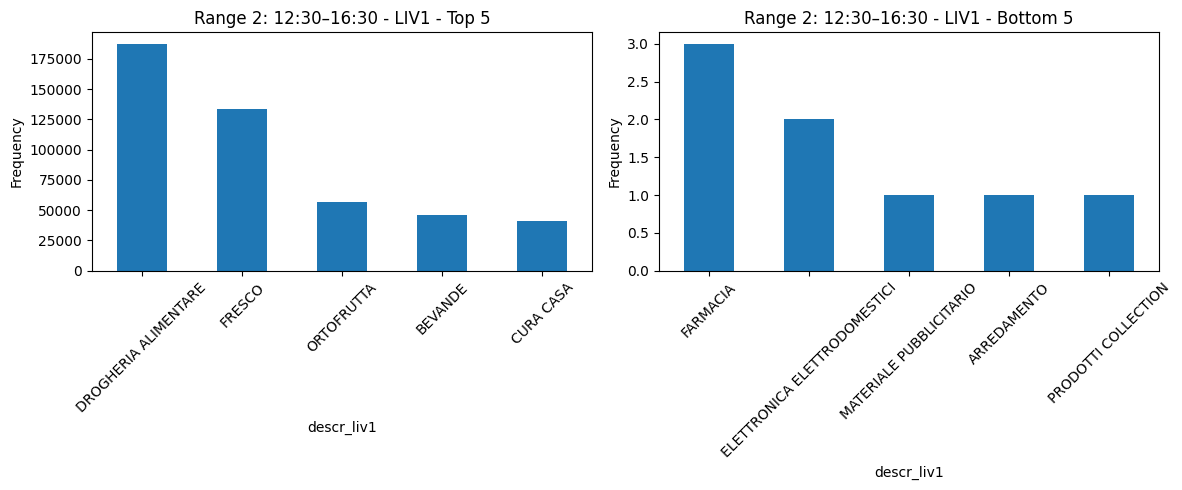

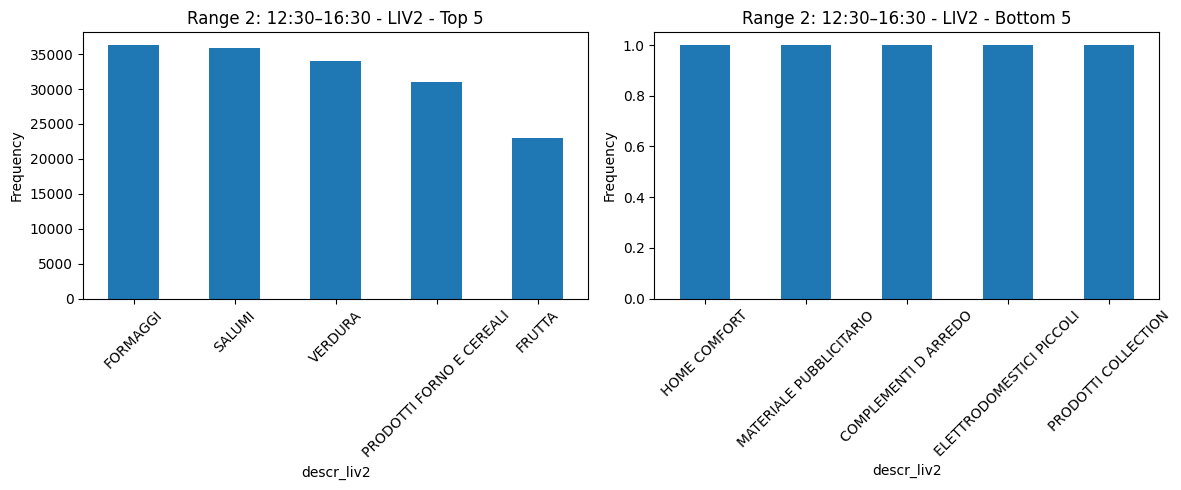

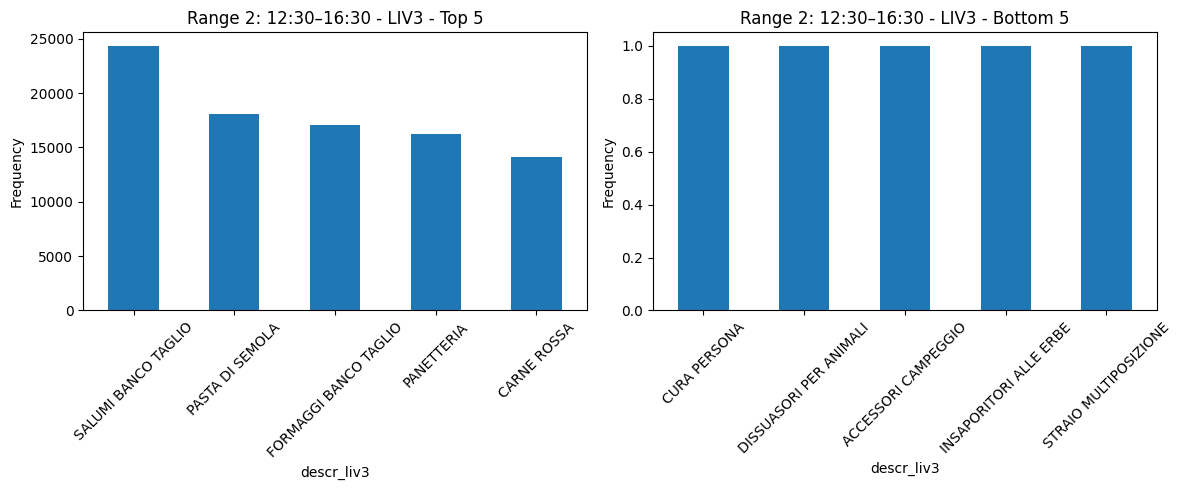

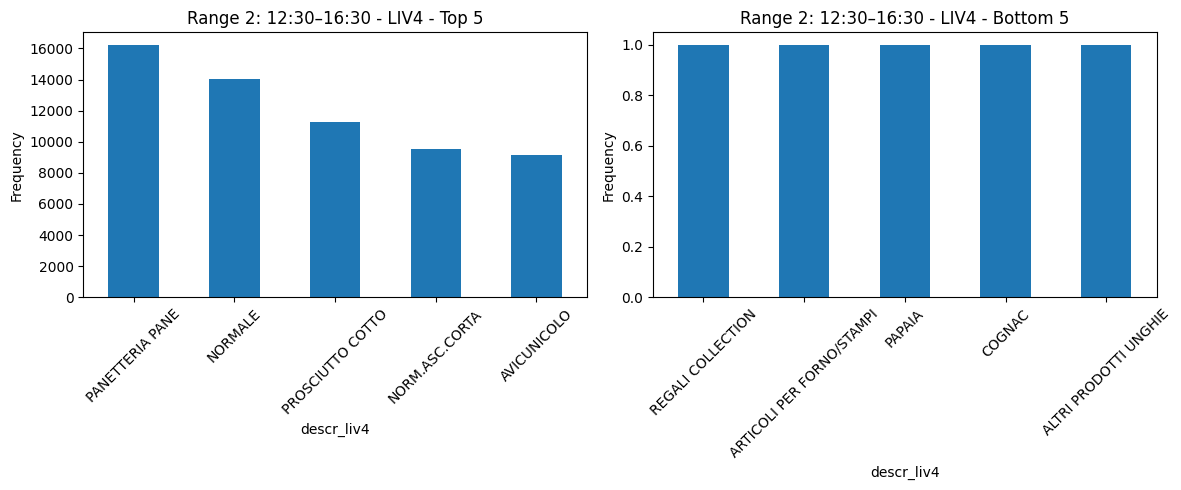

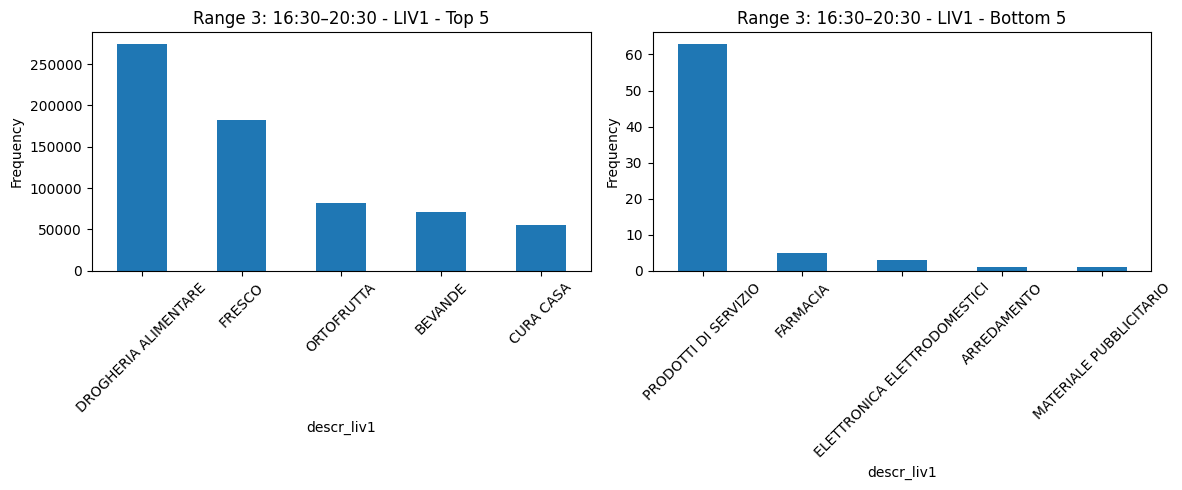

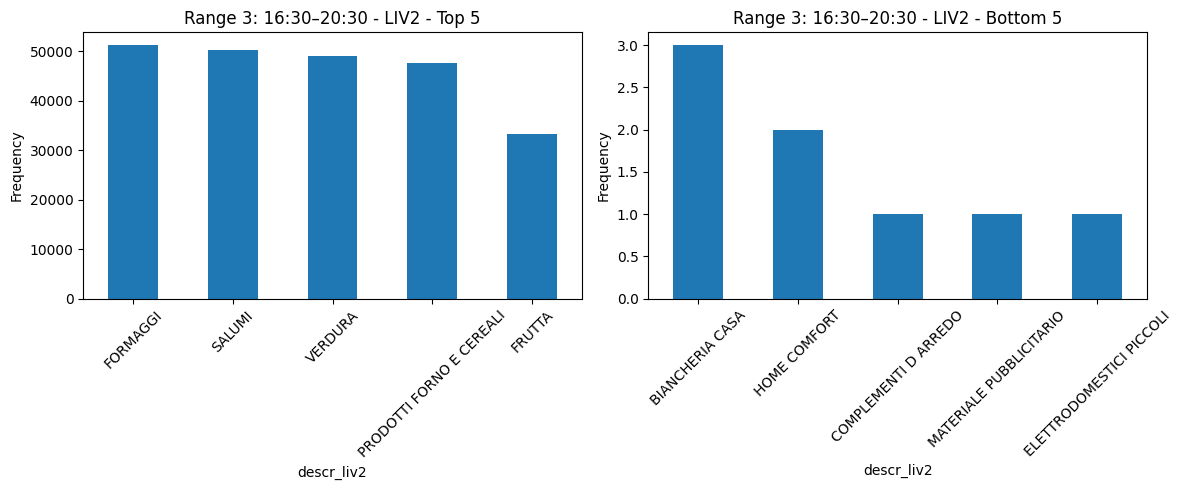

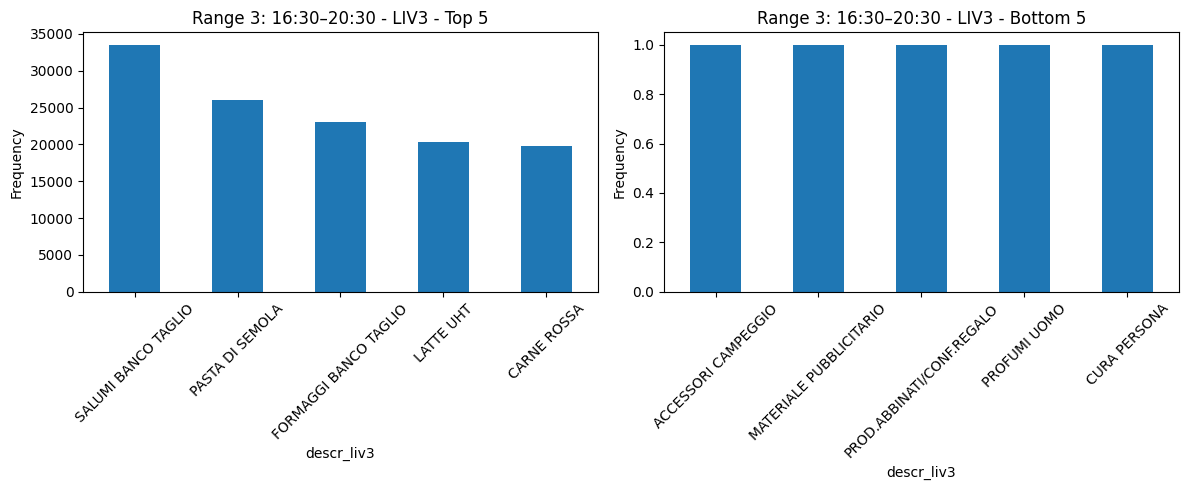

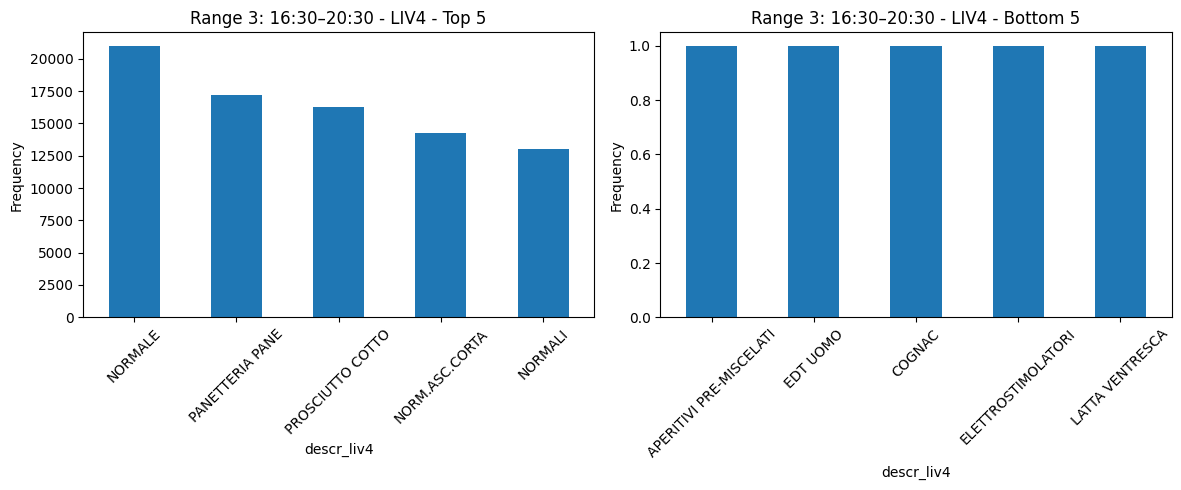

In [27]:
for range_name, start_time, end_time in slot_ranges:
    df_slot = filter_by_hour_range(df_clean, start_time, end_time)
    for level, desc_col in levels.items():
        plot_frequency(df_slot, desc_col, f"{range_name} - {level.upper()}")


# Task 3

Prepariamo il formato richiesto dalla funzione **apriori()**. 
Creiamo una matrice one-hot encoded con shape (n_transazioni, n_prodotti) dove ogni cella è 1 se quel prodotto è presente nella transazione, 0 altrimenti.

In [29]:
basket_sets = create_basket_sets(df_clean, "scontrino_id", "descr_liv4","r_qta_pezzi")

c:\Users\giova\Universita\data_mining\IDM_2025\first_classwork\src\task3.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.drop(transaction_col, axis=1).applymap(lambda x: 1 if x > 0 else 0)


Calcoliamo gli itemset frequenti con l'algoritmo Apriori tramite l'apposita funzione della libreria mlxtend.  
Per motivi relativi alla capacità della RAM configuriamo una soglia di supporto pari al 3% del numero di transazioni

In [30]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)

c:\Users\giova\PythonEnvs\env_311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Calcoliamo le regole di associazione possibili e manteniamo solo quelle con una confidenza >= 0.3

In [31]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

### Analisi dei risultati ottenuti

Quanti itemset abbiamo ottenuto ?

In [32]:
len(frequent_itemsets)

172

Visualizziamo i primi 10

In [33]:
frequent_itemsets.sort_values('support', ascending=False).head(10)

,support,itemsets
61,0.271415,(PANETTERIA PANE)
71,0.250793,(PROSCIUTTO COTTO)
54,0.249116,(NORMALE)
45,0.178327,(LATTE VACCINO)
55,0.173266,(NORMALI)
11,0.170446,(AVICUNICOLO)
21,0.169725,(BOVINO)
37,0.152936,(GRANA E SIMILI)
13,0.135958,(BANANE)
63,0.135510,(PASTE FILATE STAGIONATE)


Quante regole sono state estratte ?

In [34]:
len(rules)

55

Ordiniamo le regole per lift discendente e visualizziamo le 5 più interessanti

In [35]:
rules_sorted = rules.sort_values('lift', ascending=False)
rules_sorted[['antecedents','consequents','support','confidence','lift']].head(5)

,antecedents,consequents,support,confidence,lift
30,(NORM.ASC.LUNGA),(NORM.ASC.CORTA),0.042447,0.552240,4.128536
31,(NORM.ASC.CORTA),(NORM.ASC.LUNGA),0.042447,0.317336,4.128536
15,(SUINO),(BOVINO),0.049003,0.496936,2.927894
49,(SALAME),(PASTE FILATE STAGIONATE),0.034670,0.352188,2.598991
43,(PREPARATI GASTRON.(PANETTERIA)),(PANETTERIA PANE),0.039576,0.672296,2.477000


# Task 4

Calcoliamo gli itemset frequenti con l'algoritmo FP Growth tramite l'apposita funzione della libreria mlxtend.  
Essendo un algoritmo più veloce ed efficiente di Apriori possiamo permetterci di abbassare la soglia di supporto rispetto a prima.

In [36]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(basket_sets, min_support=0.01, use_colnames=True)

c:\Users\giova\PythonEnvs\env_311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Calcoliamo le regole di associazione possibili e manteniamo solo quelle con una confidenza >= 0.3

In [37]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

### Analisi dei risultati ottenuti

Quanti itemset abbiamo ottenuto ?

In [38]:
len(frequent_itemsets)

1356

Visualizziamo i primi 10

In [39]:
frequent_itemsets.sort_values('support', ascending=False).head(10)

,support,itemsets
41,0.271415,(PANETTERIA PANE)
0,0.250793,(PROSCIUTTO COTTO)
46,0.249116,(NORMALE)
18,0.178327,(LATTE VACCINO)
1,0.173266,(NORMALI)
50,0.170446,(AVICUNICOLO)
89,0.169725,(BOVINO)
51,0.152936,(GRANA E SIMILI)
13,0.135958,(BANANE)
24,0.135510,(PASTE FILATE STAGIONATE)


Quante regole sono state estratte ?

In [40]:
len(rules)

855

Ordiniamo le regole per lift discendente e visualizziamo le 5 più interessanti sulla base della metrica *lift*

In [41]:
rules_sorted = rules.sort_values('lift', ascending=False)
rules_sorted[['antecedents','consequents','support','confidence','lift']].head(5)

,antecedents,consequents,support,confidence,lift
412,(PIATTI),(BICCHIERI),0.016237,0.408801,6.300594
372,"(NORM.ASC.CORTA, NORMALI)",(NORM.ASC.LUNGA),0.013632,0.365824,4.759360
388,"(NORM.ASC.LUNGA, BOTTIGLIA/VASO)",(NORM.ASC.CORTA),0.011546,0.633964,4.739499
392,"(NORM.ASC.CORTA, NORMALE)",(NORM.ASC.LUNGA),0.018459,0.360808,4.694099
376,"(NORM.ASC.LUNGA, LATTE VACCINO)",(NORM.ASC.CORTA),0.013658,0.626714,4.685304


# Task 5

Costruiamo la matrice delle frequenze. Essa ha shape (n_tessere, n_prodotti)

In [42]:
X = build_frequency_matrix(df_clean)
X.shape

(9374, 1179)

Vediamo quali sono le tessere che hanno fatto più acquisti.

In [43]:
X.sum(axis=1).sort_values(ascending=False).head()

tessera
248431666901.0    104519
248409998003.0      5076
248431643506.0      5023
248431085207.0      4529
248409997600.0      4519
dtype: int64

Applichiamo la PCA a 2 componenti per ridurre la dimensionalità.

In [44]:
X_pca = apply_pca(X,2)

Visualizziamo la distribuzione dei dati.

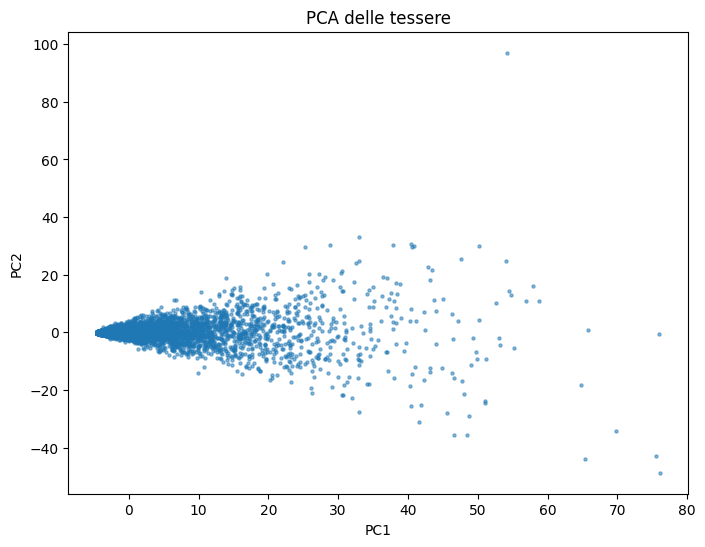

In [45]:
plot_data(X_pca,"PCA delle tessere","PC1","PC2")


La rappresentazione dei dati non sembra fornire molte informazioni. Proviamo ad usare una riduzione dei dati non lineare come UMAP.

In [46]:
X_umap_2 = apply_umap(X,2)

c:\Users\giova\PythonEnvs\env_311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Usiamo la riduzione a due componenti per poter visualizzare i dati

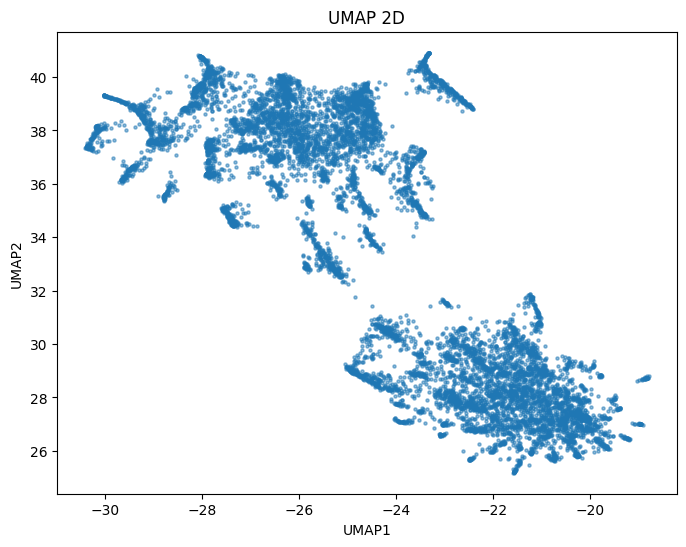

In [35]:
plot_data(X_umap_2, "UMAP 2D", "UMAP1", "UMAP2")

Per effettuare il clustering utilizziamo più componenti in modo da preservare più informazioni.  
Non possiamo però usare più componenti a causa del "problema della dimensionalità"

In [38]:
X_umap_50 = apply_umap(X,50)


c:\Users\giova\PythonEnvs\env_311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


***HDBSCAN***

Applichiamo l'algoritmo hdbscan e sulla base delle etichette ottenute calcoliamo il silhouette score

In [79]:

labels_hdbscan = apply_hdbscan(X_umap_50,300) # min_pts simile a campioni/100
score = silhouette_score(X_umap_50, labels_hdbscan)
print("Score = ", score)

c:\Users\giova\PythonEnvs\env_311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\giova\PythonEnvs\env_311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Score =  0.8003410696983337


Mostriamo qualche statistica sulla distribuzione dei cluster calcolati con hdbscan

In [ ]:
show_statistics(labels_hdbscan)

Label      Count     
----------------------
Cluster 0  4376      
Cluster 1  4998      


Plottiamo la distrubzione dei cluster calcolati con hdbscan.  
Per la visualizzazione utilizziamo i dati ridotti con umap a 2 dimensioni

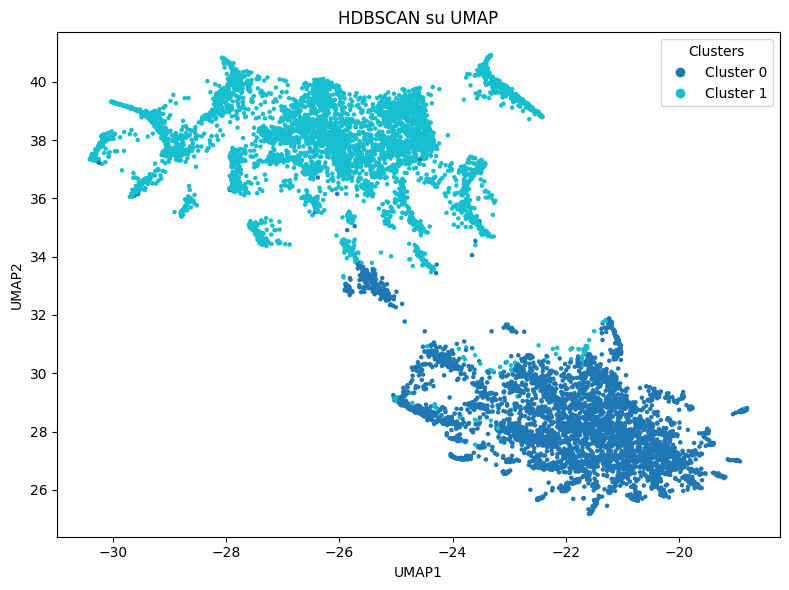

In [70]:
plot_clusters(X_umap_2, labels_hdbscan, "HDBSCAN su UMAP", "UMAP1", "UMAP2")

***DBSCAN***

Per utilizzare l'algoritmo dbscan occorre specificare due parametri:
- epsilon: raggio minimo del cluster
- min_pts: numero minimo di punti che un cluster deve contenere  

Fissiamo min_pts a 300 punti e utilizziamo il metodo k-distance per trovare il valore di epsilon ideale

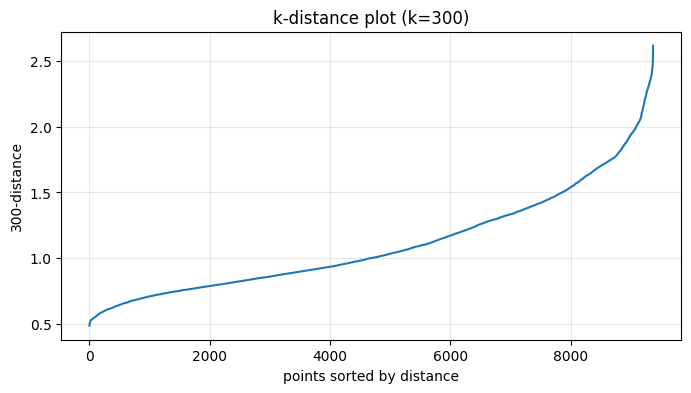

In [71]:

k_dist = plot_k_distance(X_umap_50, k=300)  

In [78]:

labels_dbscan = apply_dbscan(X_umap_50,2,300)
score = silhouette_score(X_umap_50,labels_dbscan)
print("Score = ", score)

Score =  0.642566442489624


Visualizziamo qualche statistica dei cluster ottenuti con dbscan.

In [83]:
show_statistics(labels_dbscan)

Label      Count     
----------------------
Cluster 0  4376      
Cluster 1  312       
Cluster 2  4686      


Plottiamo la distribuzione dei cluster ottenuti con dbscan.

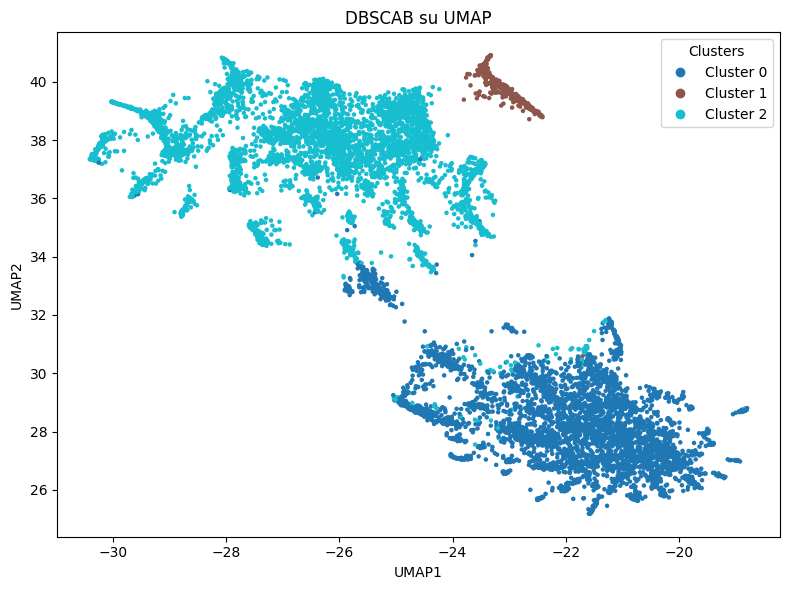

In [77]:
plot_clusters(X_umap_2, labels_dbscan, "DBSCAB su UMAP", "UMAP1", "UMAP2")

***K-Means***

L'algoritmo k-means richiede come parametro il numero di cluster k.  
Non conoscendo a priori il valore di k utilizziamo il metodo elbow per trovare il valore ideale.

In [ ]:
range_k = range(2, 11)
sil_scores = []

for k in range_k:
    labels = apply_kmeans(X_umap_50,k)
    score = silhouette_score(X_umap_50, labels)
    sil_scores.append(score)
    print(f"k={k}, silhouette score={score:.3f}")



k=2, silhouette score=0.800
k=3, silhouette score=0.528
k=4, silhouette score=0.310
k=5, silhouette score=0.339
k=6, silhouette score=0.318
k=7, silhouette score=0.319
k=8, silhouette score=0.289
k=9, silhouette score=0.302
k=10, silhouette score=0.294


Applichiamo K-Means con k = 2

In [84]:
labels_kmeans = apply_kmeans(X_umap_50,2)

Visualizziamo qualche statistica sulla distribuzione dei cluster ottenuti con k-means

In [85]:
show_statistics(labels_kmeans)

Label      Count     
----------------------
Cluster 0  4376      
Cluster 1  4998      


Plottiamo la distribuzione dei cluster ottenuti con k-means

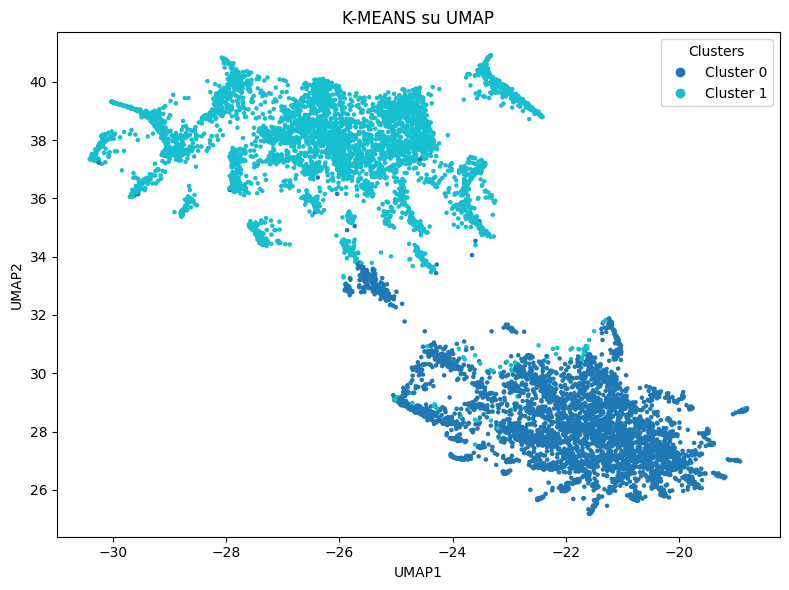

In [86]:
plot_clusters(X_umap_2, labels_kmeans, "K-MEANS su UMAP", "UMAP1", "UMAP2")